In [1]:
class FloatIIRFilter:
    def __init__(self, b0, b1, a1):
        self.b0 = b0
        self.b1 = b1
        self.a1 = a1
        # 初始化存储过去的值, y1 y2为高bit的值
        self.x1 = 0
        self.y1 = 0
    
    def process(self, x):
        # 计算当前输出
        y = self.b0 * x + self.b1 * self.x1 - self.a1 * self.y1

        # 更新历史值
        self.x1 = x
        self.y1 = y
        return y

In [2]:
import numpy as np
from scipy.signal import butter
class QuantizedIIRFilter:
    def __init__(self, b0, b1,a1, coeff_left_shift_bits=26, output_dec_bits=11):
        # 系数量化
        self.left_scale = 2 ** coeff_left_shift_bits
        # 存储量化因子
        self.output_dec_bits = output_dec_bits
        self.b0 = np.round((1 - b0) * self.left_scale)
        self.b1 = np.round((1 + b1) * self.left_scale)
        self.a1 = np.round((1 + a1) * self.left_scale)
        # print(self.left_scale)
        # print(self.output_dec_bits)
        print(self.b0, self.b1, self.a1)
        print((1 - b0) * self.left_scale, (1 + b1) * self.left_scale, (1 + a1) * self.left_scale)


        # 初始化历史变量，使用double精度
        self.x1 = np.float64(0)
        self.y1 = np.float64(0)

        

    def process(self, x):

        # 反馈部分计算
        accumuator = 0
        accumuator = (x - self.x1)* 2**self.output_dec_bits + self.y1
        # accu_ay = -self.a1*self.y1 # high precision
        accu_ay = -self.a1*(self.y1 / 2**self.output_dec_bits * 2**self.output_dec_bits)
        accu_bx = (-self.b0*x + self.b1*self.x1) * 2**self.output_dec_bits
        # add extra 0.5 lsb bias
        # accumuator = accumuator + np.floor((accu_bx + accu_ay) / self.left_scale)
        accumuator = accumuator + np.floor((accu_bx + accu_ay + self.left_scale/2) / self.left_scale)

        self.x1 = x
        self.y1 = accumuator
        accumuator = np.floor(accumuator  / 2**self.output_dec_bits)
        return accumuator

In [3]:
def signal_generator(fs, time, signal_range, start_freq, end_freq, offset=1000):
    """
    生成一个持续仿真时间的每秒频率递增的正弦波信号。
    参数：
    fs - 每秒采样点数
    time - 仿真时间（秒）
    signal_range - 信号幅度范围
    start_freq - 起始频率(Hz)
    end_freq - 终止频率(Hz)
    
    返回：
    generated_signal - 生成的信号
    """
    num_samples = fs * time  # 总样本数
    t = np.linspace(0, time, num_samples, endpoint=False)  # 时间序列
    generated_signal = np.zeros_like(t)  # 初始化信号数组

    # 逐秒递增频率，生成正弦波信号
    for i in range(time):
        freq = start_freq + i * (end_freq - start_freq) / time
        samples_per_cycle = fs / freq  # 每个周期的样本数
        num_cycles = int(fs // samples_per_cycle)  # 每秒能容纳的完整周期数

        if num_cycles >= 1:
            cycle_samples = int(num_cycles * samples_per_cycle)  # 完整周期的样本数
            t_segment = np.linspace(0, cycle_samples / fs, cycle_samples, endpoint=False)  # 当前段的时间序列
            sine_segment = np.sin(2 * np.pi * freq * t_segment)  # 生成当前频率的正弦波
            generated_signal[i * fs : i * fs + cycle_samples] = np.round(sine_segment * signal_range)  # 插入信号
            # 添加偏移量
            generated_signal[i * fs : i * fs + cycle_samples] += offset

    return generated_signal

[ 0.9991964 -0.9991964] [ 1.        -0.9983928]
53929.0 53929.0 107858.0
53928.790338754654 53928.790338754654 107857.58067751676
max_err 1.005936482216839
mean_err 0.4994535542597998


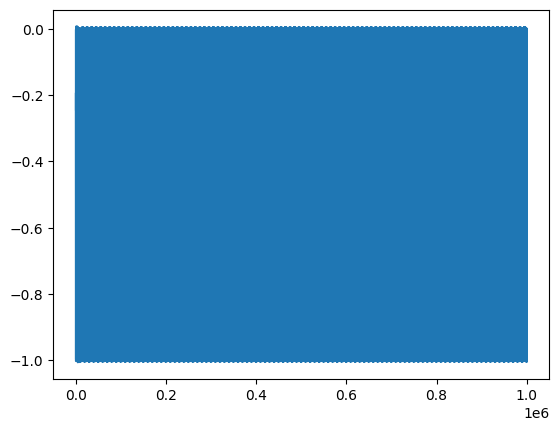

In [4]:
import matplotlib.pyplot as plt
start_freq = 1      # 起始频率
end_freq = 1     # 终止频率 2500
fs = 10000  # 每秒采样点数
time = 100  # 仿真时间
signal_range = 500
offset = 1000

generated_signal = signal_generator(fs, time, signal_range, start_freq, end_freq, offset)

fc_fs = 2.56e-4 # 6.30874000e-05 # 6.30874000e-05 # 2.00080200e-05 # 2.44276000e-06 
b,a = butter(1, 2 * fc_fs, btype="high")
print(b,a)
quantized_hpf = QuantizedIIRFilter(b[0], b[1], a[1], coeff_left_shift_bits=26, output_dec_bits=10)

scale = 1 / 2**26
# b = np.round(b / scale) * scale
# a = np.round(a / scale) * scale
float_hpf = FloatIIRFilter(b[0], b[1], a[1])

y_quantized_hpf = np.array([quantized_hpf.process(sample) for sample in generated_signal])
y_float_hpf = np.array([float_hpf.process(sample) for sample in generated_signal])

delta = y_quantized_hpf - y_float_hpf

plt.plot(delta)
print("max_err", np.max(np.abs(delta)))
print("mean_err", np.mean(np.abs(delta)))

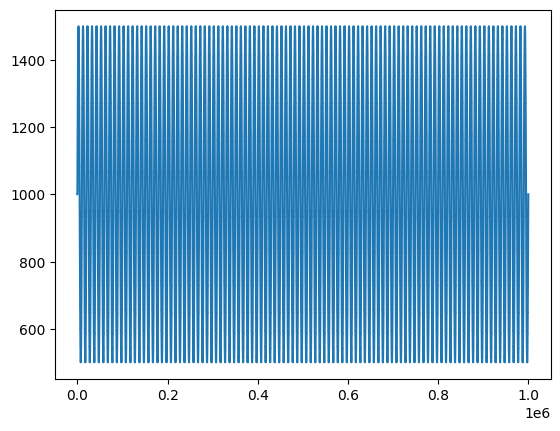

In [5]:
plt.plot(generated_signal)

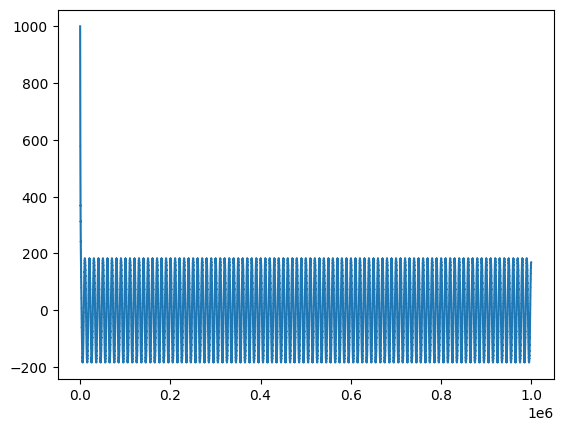

In [6]:
plt.plot(y_quantized_hpf)

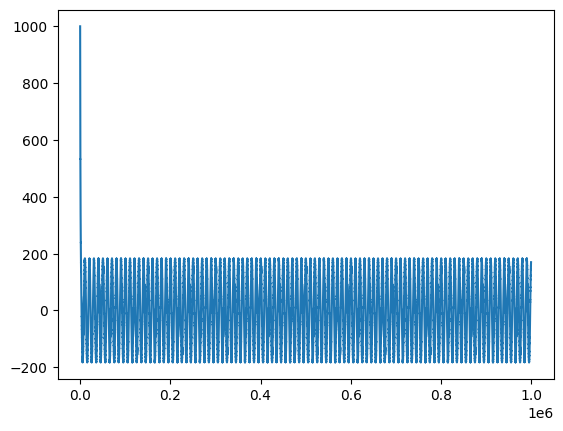

In [7]:
plt.plot(y_float_hpf[:int(len(y_float_hpf))])

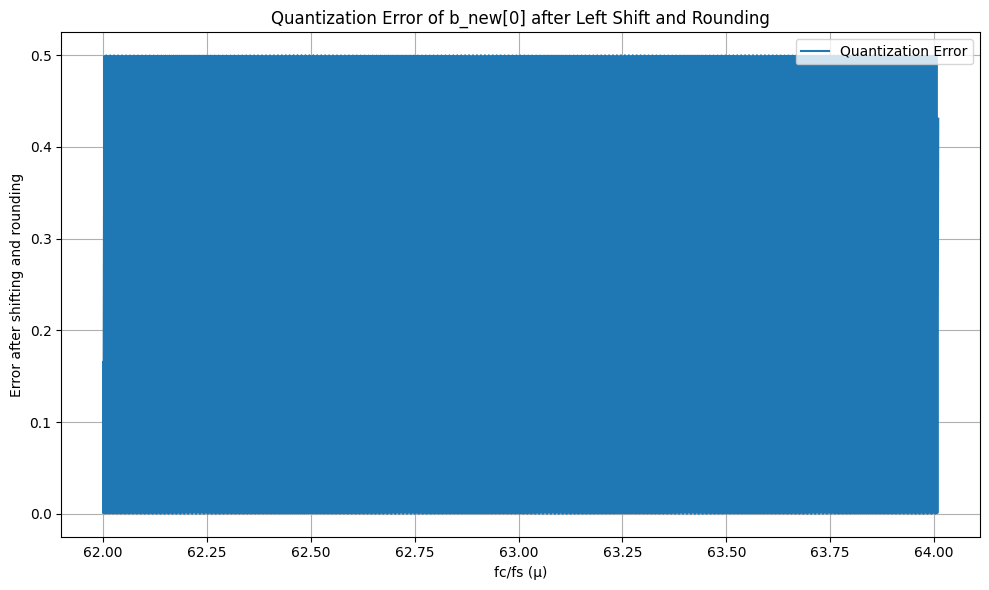

误差最小的前10个点:
 1: fc/fs = 6.30874000e-05, 误差 = 1.80304050e-06
 2: fc/fs = 6.22048200e-05, 误差 = 4.44054604e-06
 3: fc/fs = 6.39747300e-05, 误差 = 5.05894423e-06
 4: fc/fs = 6.34148100e-05, 误差 = 5.62518835e-06
 5: fc/fs = 6.27030500e-05, 误差 = 8.32229853e-06
 6: fc/fs = 6.22143100e-05, 误差 = 1.28000975e-05
 7: fc/fs = 6.26935600e-05, 误差 = 1.50725245e-05
 8: fc/fs = 6.37042600e-05, 误差 = 1.61901116e-05
 9: fc/fs = 6.37137500e-05, 误差 = 1.98930502e-05
10: fc/fs = 6.21953300e-05, 误差 = 2.15619802e-05


In [8]:
# # 2e-6 ~ 64e-6
fc_fs_values = np.arange(62e-6, 64e-6 + 0.01e-6, 0.00001e-6)
left_shift = 26
errors = []

for fc_fs in fc_fs_values:
    # 设计高通滤波器
    b, a = butter(1, 2 * fc_fs, btype="high")
    
    # 重新计算 b_new 和 a_new
    b_new = [1 - b[0], 1 + b[1]]
    a_new = [1 - a[0], 1 + a[1]]
    
    # 左移位转换并计算误差
    scaled_b0 = b_new[0] * (2 ** left_shift)
    rounded_b0 = np.round(scaled_b0)
    error = np.abs(rounded_b0 - scaled_b0)
    errors.append(error)

plt.figure(figsize=(10, 6))
plt.plot(fc_fs_values * 1e6, errors, label="Quantization Error")
plt.xlabel("fc/fs (μ)")
plt.ylabel("Error after shifting and rounding")
plt.title("Quantization Error of b_new[0] after Left Shift and Rounding")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

fc_fs_error_pairs = list(zip(fc_fs_values, errors))
sorted_pairs = sorted(fc_fs_error_pairs, key=lambda x: x[1])

# 打印误差最小的前10个点
print("误差最小的前10个点:")
for i, (fc, err) in enumerate(sorted_pairs[:10]):
    print(f"{i+1:2d}: fc/fs = {fc:.8e}, 误差 = {err:.8e}")

In [9]:
# set up time 
T = 1 / 10000
fc_fs =2.56e-4
b,a = butter(1, 2 * fc_fs, btype="high")

time = np.log(0.01) / np.log(-a[1]) 
time * T

np.float64(0.2863028448556655)